<a href="https://colab.research.google.com/github/RashmiSharma-1409/fall_detection/blob/main/Fall_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Fall Detection Menu:
1️⃣ Train
2️⃣ Test with Webcam
3️⃣ Test on Video File
Enter your choice (1/2/3): 2
📸 Please allow camera and click 'Take Photo'


<IPython.core.display.Javascript object>

✅ Photo saved to: photo.jpg


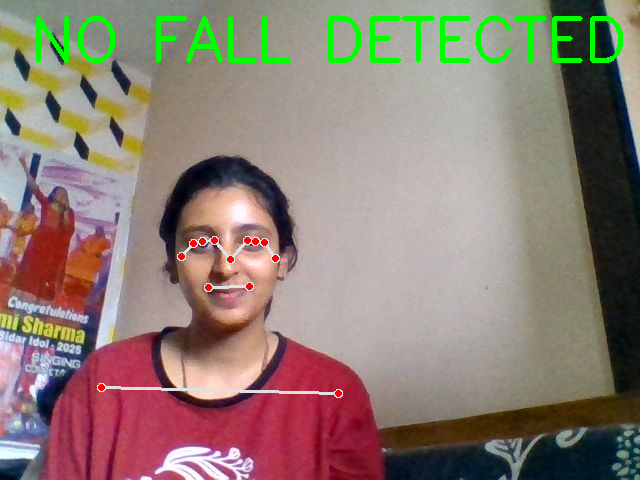

✅ No fall detected.


In [2]:
# Cell 1: Install dependencies
# !pip install mediapipe opencv-python-headless

# Cell 2: Imports
import cv2
import time
import numpy as np
import mediapipe as mp
from IPython.display import display, Javascript
from google.colab.output import eval_js
from IPython.display import Image
import io
import base64
from google.colab.patches import cv2_imshow

# Cell 3: JS-based snapshot function
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
          const div = document.createElement('div');
          const capture = document.createElement('button');
          capture.textContent = '📸 Take Photo';
          div.appendChild(capture);

          const video = document.createElement('video');
          video.style.display = 'block';
          div.appendChild(video);

          document.body.appendChild(div);

          const stream = await navigator.mediaDevices.getUserMedia({ video: true });

          video.srcObject = stream;
          await video.play();

          google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

          await new Promise((resolve) => capture.onclick = resolve);

          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getTracks().forEach(track => track.stop());
          div.remove();

          const dataUrl = canvas.toDataURL('image/jpeg', quality);
          return dataUrl;
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = io.BytesIO(base64.b64decode(data.split(',')[1]))
    with open(filename, 'wb') as f:
        f.write(binary.getbuffer())
    return filename

# Cell 4: Pose and fall detection logic
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

def detect_fall(landmarks):
    left_hip = landmarks[mp_pose.PoseLandmark.LEFT_HIP.value]
    right_hip = landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value]
    if left_hip.visibility < 0.5 or right_hip.visibility < 0.5:
        return False
    avg_hip_y = (left_hip.y + right_hip.y) / 2
    return avg_hip_y > 0.75

def train_model():
    print("🧠 Training model (simulated)...")
    for i in range(3):
        print(f"Epoch {i+1}/3")
        time.sleep(1)
    print("✅ Model training complete.")

def webcam_test_colab():
    print("📸 Please allow camera and click 'Take Photo'")
    photo_path = take_photo()
    print('✅ Photo saved to:', photo_path)

    image = cv2.imread(photo_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = pose.process(image_rgb)

    fall_detected = False
    if result.pose_landmarks:
        mp_drawing.draw_landmarks(image, result.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        fall_detected = detect_fall(result.pose_landmarks.landmark)

        if fall_detected:
            cv2.putText(image, 'FALL DETECTED!', (30, 60), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 4)
        else:
            cv2.putText(image, 'NO FALL DETECTED', (30, 60), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 4)
    else:
        cv2.putText(image, 'NO PERSON DETECTED', (30, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 0, 0), 4)

    cv2_imshow(image)

    if fall_detected:
        print("🚨 FALL DETECTED!")
    else:
        print("✅ No fall detected.")

def test_on_video(video_path):
    cap = cv2.VideoCapture(video_path)
    pose_video = mp.solutions.pose.Pose(static_image_mode=False, min_detection_confidence=0.5)
    fall_detected = False

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose_video.process(frame_rgb)
        if results.pose_landmarks:
            if detect_fall(results.pose_landmarks.landmark):
                fall_detected = True
                print("🚨 Fall detected in video!")
        cv2.imshow('Video Fall Detection', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    if not fall_detected:
        print("✅ No fall detected in video.")

# Cell 5: Menu
def main():
    print(" Fall Detection Menu:")
    print("1️⃣ Train")
    print("2️⃣ Test with Webcam")
    print("3️⃣ Test on Video File")
    choice = input("Enter your choice (1/2/3): ").strip()

    if choice == "1":
        train_model()
    elif choice == "2":
        webcam_test_colab()
    elif choice == "3":
        video_path = input("Enter path to video file (.mp4): ").strip()
        test_on_video(video_path)
    else:
        print("❌ Invalid choice. Please enter 1, 2 or 3.")

# Run the menu
main()